In [1]:
# Import Custom Modules
from src.Cleaner import cleaning
from src.Import import load_pitch_data_from_s3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, plot_confusion_matrix, log_loss, make_scorer

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from scipy import stats
%matplotlib inline

ModuleNotFoundError: No module named 'src'

In [56]:
from tqdm import tqdm
getattr(tqdm, '_instances', {}).clear() 

In [3]:
files=['data/barrell BREAKING.csv','data/barrell FAST.csv','data/barrell OFFSPEED.csv','data/flare:burner BREAKING.csv','data/flare:burner FAST.csv',
       'data/flare:burner OFFSPEED.csv','data/no contact BREAKING.csv','data/no contact FAST.csv','data/no contact OFFSPEED.csv','data/poor:top BREAKING.csv',
      'data/poor:top OFFSPEED.csv','data/poor:top FAST.csv','data/poor:under BREAKING.csv','data/poor:under OFFSPEED.csv','data/poor:under FAST.csv',
      'data/poor:weak BREAKING.csv','data/poor:weak OFFSPEED.csv','data/poor:weak FAST.csv','data/solid contact BREAKING.csv',
       'data/solid contact OFFSPEED.csv','data/solid contact FAST.csv']

In [9]:
file=load_pitch_data_from_s3(files)

In [12]:
file=cleaning(file)

In [13]:
data=file.copy()
data=data.drop(columns='contact quality')

In [17]:
# Split into test/train, using the same random state for everyone
y=file['contact quality'].values
X=data.values
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [46]:
data

,release_speed,release_pos_x,release_pos_z,zone,stand,p_throws,balls,strikes,pfx_x,pfx_z,...,release_pos_y,at_bat_number,pitch_number,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment,fast ball,offspeed,breaking
0,79.6,-1.9574,6.2977,2.0,1,1,3,2,0.9823,-0.8014,...,54.6449,84,7,4,4,0,0,0,0,1
1,78.2,-2.2382,6.0700,12.0,0,1,0,1,1.9456,0.7637,...,55.7564,63,2,3,3,0,0,0,0,1
2,84.0,2.0231,6.4508,5.0,1,0,0,0,-0.3098,0.4272,...,55.3947,39,1,2,0,0,0,0,0,1
3,86.5,-0.3244,6.8074,8.0,1,1,2,1,0.0353,0.4745,...,54.4286,36,4,2,1,1,0,0,0,1
4,80.0,-1.7519,5.9376,7.0,0,1,1,1,0.3212,-0.9366,...,54.9763,35,3,3,3,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808,87.8,-1.4583,6.4755,2.0,0,1,1,1,0.2605,0.7106,...,54.4534,12,3,0,0,0,0,1,0,0
4809,92.7,-0.9541,6.5946,13.0,1,1,0,1,-1.0402,1.4334,...,55.4399,9,2,3,0,0,0,1,0,0
4810,92.2,-2.5181,5.0753,12.0,1,1,2,2,-0.7572,1.3019,...,54.2988,7,5,1,0,0,1,1,0,0
4811,95.4,-2.2056,5.9545,6.0,0,1,1,2,-0.7903,0.8964,...,54.3803,6,4,0,0,0,0,1,0,0


In [22]:
# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators=10,
                           max_features='auto',
                           random_state=123)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
print(f"log loss = {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy = {rf.score(X_test, y_test)}")

log loss = 0.9092159695662608
accuracy = 0.8035319727000442


In [23]:
print(confusion_matrix(y_test, pred))

[[48570   829]
 [11175   525]]


In [54]:
feature_importances = np.argsort(rf.feature_importances_)
print("top five:", list(data.columns[feature_importances[::-1][0:5]]))

top five: ['plate_z', 'plate_x', 'vz0', 'release_spin_rate', 'ay']


 Feature ranking:
1. pfx_z (0.031997)
2. release_pos_z (0.031354)
3. release_pos_x (0.031310)
4. pfx_x (0.030582)
5. zone (0.024995)
6. release_speed (0.024601)
7. balls (0.007790)
8. strikes (0.007039)
9. stand (0.004138)
10. p_throws (0.001389)


Text(0.5, 1.0, 'Feature Importances')

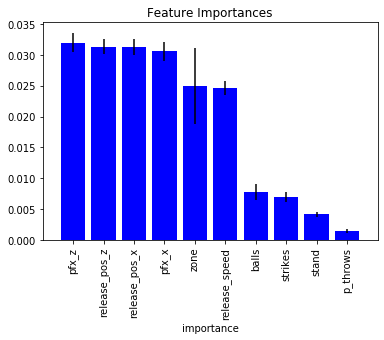

In [51]:
#Calculate the standard deviation for feature importances across all trees

n = 10 # top 10 features
rf = RandomForestClassifier(n_estimators=10,
                           max_features='auto',
                           random_state=123)
rf.fit(X_train, y_train)
importances = rf.feature_importances_[:n]
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = list(data.columns[indices])

# Print the feature ranking
print(" Feature ranking:")

for f in range(n):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

# Plot the feature importances of the forest
fig, ax = plt.subplots()

ax.bar(range(10), importances[indices], yerr=std[indices], color="b", align="center")
ax.set_xticks(range(10))
ax.set_xticklabels(features, rotation = 90)
ax.set_xlim([-1, 10])
ax.set_xlabel("importance")
ax.set_title("Feature Importances")

In [2]:
importances

NameError: name 'importances' is not defined

Text(0.5, 1.0, 'Accuracy vs Num Trees')

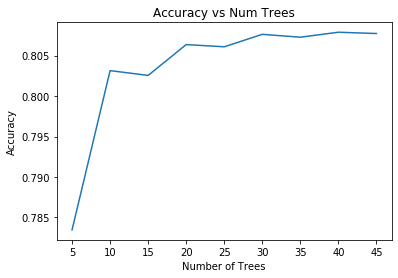

In [39]:
#modifying the number of trees
num_trees = range(5, 50, 5)
accuracies = []
for n in num_trees:
    tot = 0
    for i in range(5):
        rf = RandomForestClassifier(n_estimators=n)
        rf.fit(X_train, y_train)
        tot += rf.score(X_test, y_test)
    accuracies.append(tot / 5)
fig, ax = plt.subplots()
ax.plot(num_trees, accuracies)
ax.set_xlabel("Number of Trees")
ax.set_ylabel("Accuracy")
ax.set_title('Accuracy vs Num Trees')

In [1]:
num_features = range(1,2)
accuracies = []
for n in num_features:
    tot = 0
    for i in range(5):
        rf = RandomForestClassifier(n_estimators=20,max_features=n)
        rf.fit(X_train, y_train)
        tot += rf.score(X_test, y_test)
    accuracies.append(tot / 5)
fig, ax = plt.subplots()
ax.plot(num_features, accuracies)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Accuracy")
ax.set_title('Accuracy vs Num Features')

NameError: name 'RandomForestClassifier' is not defined

top five: ['breaking', 'p_throws', 'fast ball', 'of_fielding_alignment', 'on_3b']


In [3]:
plot_roc(X, y, RandomForestClassifier, 'Random_Forest', n_estimators=10, max_features=20)

NameError: name 'plot_roc' is not defined